# **LSTM**

Berikut adalah kumpulan kode yang digunakan untuk melakukan berbagai _test case_ pada bagian LSTM.

## **Dataset**

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Dense, TextVectorization, Embedding, Dropout, LSTM, Input, Bidirectional
from keras.optimizers import Adam
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import F1Score

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

from sklearn.metrics import f1_score, classification_report

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Plotter function
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Dataset
train_text = pd.read_csv('train.csv').drop(columns=['id'])
valid_text = pd.read_csv('valid.csv').drop(columns=['id'])
test_text = pd.read_csv('test.csv').drop(columns=['id'])

## **EDA**

In [ ]:
train_text.head()

,text,label
0,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,Ibu pernah bekerja di grab indonesia,neutral
3,Paling suka banget makan siang di sini ayam sa...,positive
4,Pelayanan bus DAMRI sangat baik,positive


In [ ]:
train_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    500 non-null    object
 1   label   500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


In [ ]:
print("Missing values in train text:", train_text['text'].isnull().sum())
print("Missing values in valid text:", valid_text['text'].isnull().sum())
print("Missing values in test text:", test_text['text'].isnull().sum())

print("Missing values in train label:", train_text['label'].isna().sum())
print("Missing values in valid label:", valid_text['label'].isna().sum())
print("Missing values in test label:", test_text['label'].isna().sum())

Missing values in train text: 0
Missing values in valid text: 0
Missing values in test text: 0
Missing values in train label: 0
Missing values in valid label: 0
Missing values in test label: 0


## **Data Preprocessing**

In [ ]:
# Preprocessing
train_text['text'] = train_text['text'].astype(str)
valid_text['text'] = valid_text['text'].astype(str)
test_text['text'] = test_text['text'].astype(str)

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train_text['label'] = train_text['label'].map(label_map).astype('int32')
valid_text['label'] = valid_text['label'].map(label_map).astype('int32')
test_text['label'] = test_text['label'].map(label_map).astype('int32')

X_train = train_text['text']
y_train = train_text['label']
X_valid = valid_text['text']
y_valid = valid_text['label']
X_test = test_text['text']
y_test = test_text['label']

In [ ]:
# Text Vectorization
vectorize_layer = TextVectorization(max_tokens=5000, output_mode='int', output_sequence_length=77)
vectorize_layer.adapt(X_train)

In [ ]:
early_stopping_callback = EarlyStopping(
        monitor='val_f1_score',
        patience=3,
        mode='max',
        restore_best_weights=True
    )

## **Percobaan Simple RNN**

### **Pengaruh Jumlah Layer**

#### **Variasi 1**

In [ ]:
# Variasi 1 - 1 Layer RNN
model_layer_1 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_layer_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,187 (723.39 KB)

 Trainable params: 185,187 (723.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_layer_1.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_layer_1 = model_layer_1.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - f1_score_macro: 0.4625 - loss: 1.1296 - val_f1_score_macro: 0.4082 - val_loss: 1.0919
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4719 - loss: 1.0563 - val_f1_score_macro: 0.4542 - val_loss: 1.0715


C:\Users\Zaki\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_f1_score` which is not available. Available metrics are: f1_score_macro,loss,val_f1_score_macro,val_loss
  current = self.get_monitor_value(logs)


Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4924 - loss: 0.9842 - val_f1_score_macro: 0.4531 - val_loss: 1.0076
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4999 - loss: 0.8674 - val_f1_score_macro: 0.4626 - val_loss: 1.0358
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4957 - loss: 0.7066 - val_f1_score_macro: 0.4705 - val_loss: 0.9348
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1_score_macro: 0.4959 - loss: 0.5662 - val_f1_score_macro: 0.4833 - val_loss: 0.9041
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4961 - loss: 0.3576 - val_f1_score_macro: 0.4752 - val_loss: 0.9287
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.5009 - loss: 0.2775 - val_f1_score_macro: 0.4729 - val_loss: 0.9790
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4992 - loss: 0.1575 - val_f1_score_macro: 0.4769 - val_loss: 1.0341
Epoch 10/50
16/16 ━━━━━━━━━

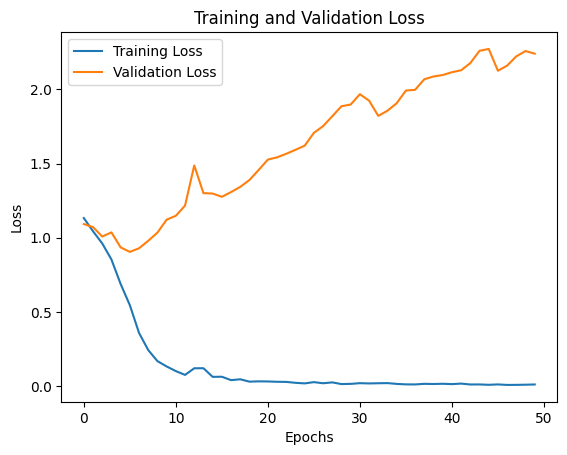

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score_macro: 0.4773 - loss: 2.1322 


[2.110212564468384, 0.473630428314209]

In [ ]:
plot_history(history_layer_1)

model_layer_1.evaluate(X_test.values, y_test)

#### **Variasi 2**

In [ ]:
# Variasi 2 - 2 Layer RNN
model_layer_2 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(32, return_sequences=True),
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_layer_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 77, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,267 (731.51 KB)

 Trainable params: 187,267 (731.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_layer_2.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_layer_2 = model_layer_2.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - f1_score_macro: 0.4588 - loss: 1.0967 - val_f1_score_macro: 0.4366 - val_loss: 1.0720
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4554 - loss: 0.9762 - val_f1_score_macro: 0.4017 - val_loss: 1.0305
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score_macro: 0.4499 - loss: 0.9060 - val_f1_score_macro: 0.4585 - val_loss: 1.0196
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4733 - loss: 0.7857 - val_f1_score_macro: 0.4563 - val_loss: 0.9812
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4775 - loss: 0.5990 - val_f1_score_macro: 0.4648 - val_loss: 1.1103
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4897 - loss: 0.4202 - val_f1_score_macro: 0.4809 - val_loss: 1.1549
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score_macro: 0.4915 - loss: 0.3152 - val_f1_score_macro: 0.4896 - val_loss: 1.2261
Epoch 8/50
16/16 ━━━━━━━━━━

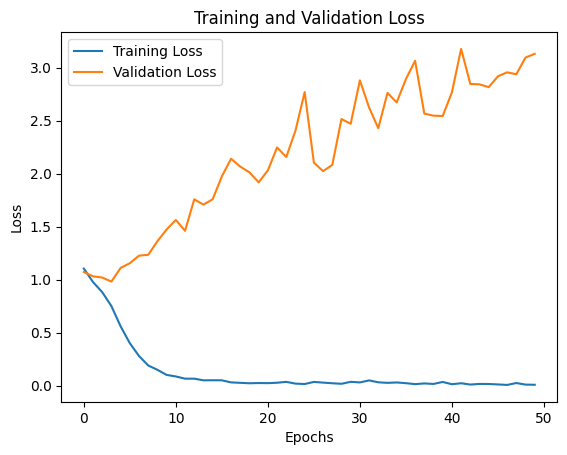

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score_macro: 0.4899 - loss: 3.2496 


[3.321539878845215, 0.4865334928035736]

In [ ]:
plot_history(history_layer_2)

model_layer_2.evaluate(X_test.values, y_test)

#### **Variasi 3**

In [ ]:
# Variasi 3 - 3 Layer RNN
model_layer_3 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(32, return_sequences=True),
            LSTM(32, return_sequences=True),
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_layer_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 77, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 77, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,347 (739.64 KB)

 Trainable params: 189,347 (739.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_layer_3.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_layer_3 = model_layer_3.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - f1_score_macro: 0.4651 - loss: 1.1998 - val_f1_score_macro: 0.4757 - val_loss: 1.1196
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - f1_score_macro: 0.4626 - loss: 1.0930 - val_f1_score_macro: 0.4953 - val_loss: 1.1471
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - f1_score_macro: 0.4835 - loss: 0.8647 - val_f1_score_macro: 0.4820 - val_loss: 1.1329
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - f1_score_macro: 0.4869 - loss: 0.7247 - val_f1_score_macro: 0.4831 - val_loss: 1.1314
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - f1_score_macro: 0.4796 - loss: 0.5653 - val_f1_score_macro: 0.4999 - val_loss: 1.1937
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - f1_score_macro: 0.4937 - loss: 0.4534 - val_f1_score_macro: 0.4892 - val_loss: 1.2676
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - f1_score_macro: 0.4895 - loss: 0.3063 - val_f1_score_macro: 0.4903 - val_loss: 1.3668
Epoch 8/50
16/16 ━━━━━━━━━━

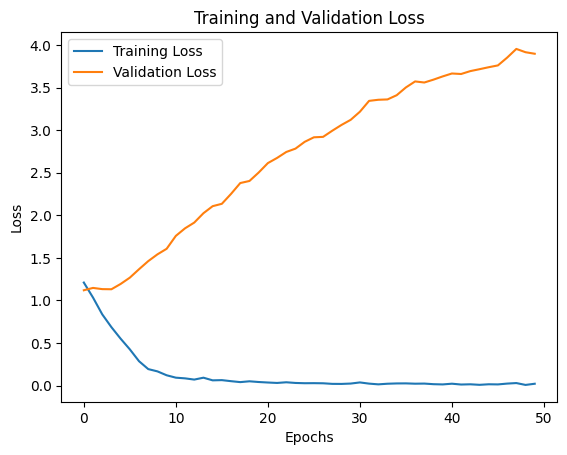

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score_macro: 0.4813 - loss: 3.1361


[3.1751043796539307, 0.4777250587940216]

In [ ]:
plot_history(history_layer_3)

model_layer_3.evaluate(X_test.values, y_test)

### **Pengaruh Jumlah Cell**

#### **Variasi 1**

In [ ]:
# Variasi 1
model_cell_1 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_cell_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,187 (723.39 KB)

 Trainable params: 185,187 (723.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_cell_1.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_cell_1 = model_cell_1.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - f1_score_macro: 0.4753 - loss: 1.0987 - val_f1_score_macro: 0.3800 - val_loss: 1.0444
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4508 - loss: 0.9729 - val_f1_score_macro: 0.4998 - val_loss: 1.0948
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4627 - loss: 0.8866 - val_f1_score_macro: 0.4077 - val_loss: 0.9922
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4541 - loss: 0.7448 - val_f1_score_macro: 0.4767 - val_loss: 0.9544
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4819 - loss: 0.5680 - val_f1_score_macro: 0.4875 - val_loss: 0.9905
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4888 - loss: 0.4276 - val_f1_score_macro: 0.4934 - val_loss: 1.0287
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4929 - loss: 0.3416 - val_f1_score_macro: 0.4817 - val_loss: 1.0316
Epoch 8/50
16/16 ━━━━━━━━━━

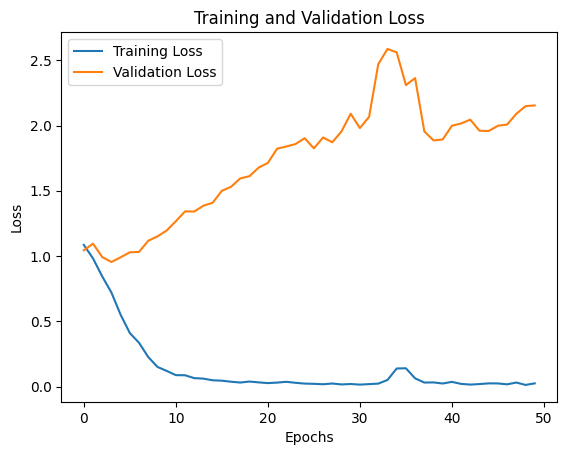

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score_macro: 0.4900 - loss: 2.0650 


[1.984969139099121, 0.4827241003513336]

In [ ]:
plot_history(history_cell_1)

model_cell_1.evaluate(X_test.values, y_test)

#### **Variasi 2**

In [ ]:
# Variasi 2
model_cell_2 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(64),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_cell_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,851 (745.51 KB)

 Trainable params: 190,851 (745.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_cell_2.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_cell_2 = model_cell_2.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - f1_score_macro: 0.4902 - loss: 1.1128 - val_f1_score_macro: 0.4015 - val_loss: 1.0655
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4740 - loss: 0.9903 - val_f1_score_macro: 0.4257 - val_loss: 1.0026
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4722 - loss: 0.9179 - val_f1_score_macro: 0.4223 - val_loss: 1.0271
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4785 - loss: 0.7642 - val_f1_score_macro: 0.4400 - val_loss: 0.9791
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1_score_macro: 0.4885 - loss: 0.5805 - val_f1_score_macro: 0.4482 - val_loss: 1.0338
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4914 - loss: 0.4363 - val_f1_score_macro: 0.4524 - val_loss: 1.0523
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4989 - loss: 0.3177 - val_f1_score_macro: 0.4674 - val_loss: 1.0673
Epoch 8/50
16/16 ━━━━━━━━━━

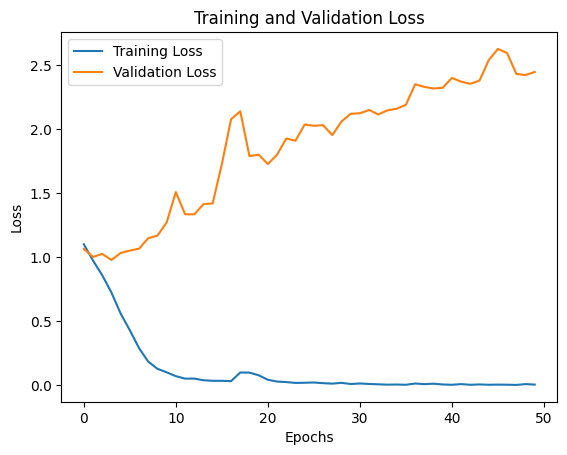

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score_macro: 0.4753 - loss: 2.6544 


[2.616244316101074, 0.4725218713283539]

In [ ]:
plot_history(history_cell_2)

model_cell_2.evaluate(X_test.values, y_test)

#### **Variasi 3**

In [ ]:
# Variasi 3
model_cell_3 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(128),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_cell_3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,323 (813.76 KB)

 Trainable params: 208,323 (813.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_cell_3.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_cell_3 = model_cell_3.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - f1_score_macro: 0.4873 - loss: 1.0847 - val_f1_score_macro: 0.4734 - val_loss: 1.0574
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4889 - loss: 0.9651 - val_f1_score_macro: 0.4711 - val_loss: 0.9881
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score_macro: 0.4835 - loss: 0.8566 - val_f1_score_macro: 0.4779 - val_loss: 1.0212
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score_macro: 0.5006 - loss: 0.6596 - val_f1_score_macro: 0.4773 - val_loss: 1.0935
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.5003 - loss: 0.4498 - val_f1_score_macro: 0.4332 - val_loss: 1.2208
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score_macro: 0.4944 - loss: 0.3011 - val_f1_score_macro: 0.4947 - val_loss: 1.6475
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score_macro: 0.5088 - loss: 0.2607 - val_f1_score_macro: 0.4713 - val_loss: 1.1990
Epoch 8/50
16/16 ━━━━━━━━━━

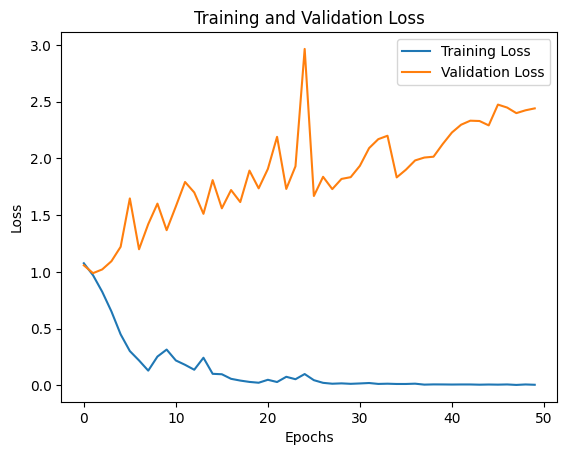

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score_macro: 0.4539 - loss: 2.7788


[2.616992235183716, 0.4552343785762787]

In [ ]:
plot_history(history_cell_3)

model_cell_3.evaluate(X_test.values, y_test)

### **Pengaruh Arah**

#### **Variasi Unidirectional**

In [ ]:
# Unidirectional
model_uni = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_uni.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,187 (723.39 KB)

 Trainable params: 185,187 (723.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_uni.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_uni = model_uni.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - f1_score_macro: 0.4707 - loss: 1.0996 - val_f1_score_macro: 0.4483 - val_loss: 1.0821
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4473 - loss: 1.0304 - val_f1_score_macro: 0.4446 - val_loss: 1.0544
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4498 - loss: 0.9217 - val_f1_score_macro: 0.4549 - val_loss: 1.0159
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4568 - loss: 0.7951 - val_f1_score_macro: 0.4583 - val_loss: 0.9837
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4742 - loss: 0.6585 - val_f1_score_macro: 0.4623 - val_loss: 1.0604
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4875 - loss: 0.5246 - val_f1_score_macro: 0.4876 - val_loss: 0.9742
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4954 - loss: 0.3769 - val_f1_score_macro: 0.4871 - val_loss: 1.0423
Epoch 8/50
16/16 ━━━━━━━━━━

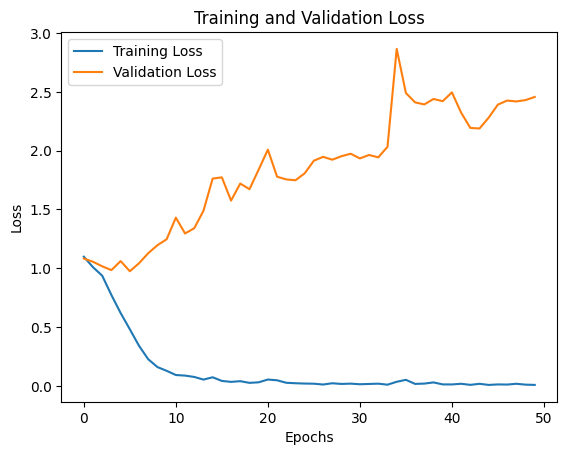

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score_macro: 0.4830 - loss: 2.1189 


[2.1677896976470947, 0.4775260388851166]

In [ ]:
plot_history(history_uni)

model_uni.evaluate(X_test.values, y_test)

#### **Variasi Bidirectional**

In [ ]:
# Bidirectional
model_bi = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            Bidirectional(LSTM(32)),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_bi.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,803 (737.51 KB)

 Trainable params: 188,803 (737.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_bi.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_bi = model_bi.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - f1_score_macro: 0.5009 - loss: 1.1197 - val_f1_score_macro: 0.4197 - val_loss: 1.0662
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4662 - loss: 1.0313 - val_f1_score_macro: 0.4555 - val_loss: 1.0187
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4749 - loss: 0.9024 - val_f1_score_macro: 0.4171 - val_loss: 0.9820
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4786 - loss: 0.7851 - val_f1_score_macro: 0.4841 - val_loss: 0.9496
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4925 - loss: 0.6381 - val_f1_score_macro: 0.4942 - val_loss: 0.9571
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4972 - loss: 0.4700 - val_f1_score_macro: 0.4829 - val_loss: 0.9508
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4921 - loss: 0.3361 - val_f1_score_macro: 0.4828 - val_loss: 0.9746
Epoch 8/50
16/16 ━━━━━━━━━━

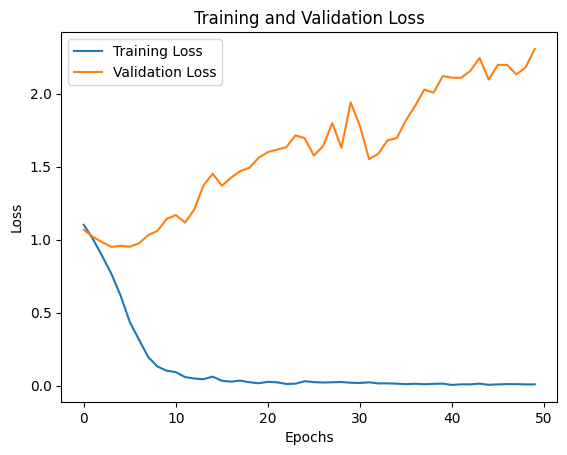

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score_macro: 0.4845 - loss: 2.4365 


[2.3459513187408447, 0.48185816407203674]

In [ ]:
plot_history(history_bi)

model_bi.evaluate(X_test.values, y_test)

## **Perbandingan dengan model from _scratch_**

In [ ]:
config = vectorize_layer.get_config()
sequence_length_from_config = config['output_sequence_length']

print(sequence_length_from_config)

77


In [ ]:
vectorized_train_text = vectorize_layer(X_train)
vectorized_valid_text = vectorize_layer(X_valid)
vectorized_test_text = vectorize_layer(X_test)

In [ ]:
model_keras = Sequential([
          Embedding(
              input_dim=len(vectorize_layer.get_vocabulary()),
              output_dim=64,
              mask_zero=True
          ),

          # RNN layers for sequence modeling
          Bidirectional(LSTM(32)),

          # Dense layers
          Dropout(0.5),
          Dense(16, activation='relu'),
          Dropout(0.3),
          Dense(3, activation='softmax')
      ])

In [ ]:
model_keras.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_keras = model_keras.fit(vectorized_train_text, y_train, epochs=50, validation_data=(vectorized_valid_text, y_valid), callbacks=[early_stopping_callback])
model_keras.summary()
model_keras.save("keras_model.h5")

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - f1_score_macro: 0.4853 - loss: 1.1550 - val_f1_score_macro: 0.4931 - val_loss: 1.1141
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4980 - loss: 1.0669 - val_f1_score_macro: 0.4726 - val_loss: 1.0929
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4767 - loss: 0.9719 - val_f1_score_macro: 0.4162 - val_loss: 1.0532
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4658 - loss: 0.8712 - val_f1_score_macro: 0.4382 - val_loss: 0.9986
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4754 - loss: 0.7025 - val_f1_score_macro: 0.4940 - val_loss: 0.9198
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - f1_score_macro: 0.4931 - loss: 0.4960 - val_f1_score_macro: 0.4812 - val_loss: 0.9021
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4940 - loss: 0.3369 - val_f1_score_macro: 0.4735 - val_loss: 0.9191
Epoch 8/50
16/16 ━━━━━━━━━━

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 566,411 (2.16 MB)

 Trainable params: 188,803 (737.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 377,608 (1.44 MB)

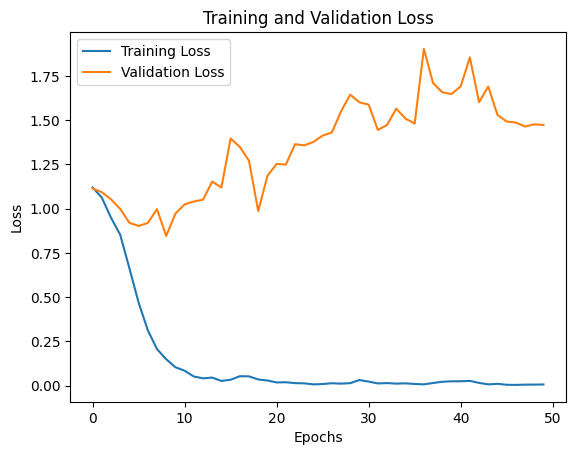

In [ ]:
plot_history(history_keras)

In [ ]:
keras_loss, keras_f1_macro = model_keras.evaluate(vectorized_test_text, y_test, verbose=0)
print(f"Keras Test Loss: {keras_loss:.4f}")
print(f"Keras Test F1-score (macro): {keras_f1_macro:.4f}")

Keras Test Loss: 1.3997
Keras Test F1-score (macro): 0.4791


In [ ]:
from lstm_layer import *

model_custom = Model([
    Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64),
    Bidirectional(LSTM_c(units=32, input_size=64)),
    Dropout(0.5),
    Dense(16, input_size=64, activation_function='relu'),
    Dropout(0.3),
    Dense(3, input_size=16, activation_function='softmax')
])

In [ ]:
model_custom.load_weights_from_keras_model('keras_model.h5')

In [ ]:
keras_output = model_keras.predict(vectorized_test_text)
custom_output = model_custom.predict(vectorized_test_text)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
print("\nSampel Output Mentah (5 sampel pertama):")
for i in range(min(5, len(keras_output))):
    print(f"Sampel {i+1}:")
    print(f"  Keras : {keras_output[i]}")
    print(f"  Custom: {custom_output[i]}")
    print("-" * 20)


Sampel Output Mentah (5 sampel pertama):
Sampel 1:
  Keras : [0.04768137 0.04381198 0.90850663]
  Custom: [0.78032523 0.13101201 0.08866271]
--------------------
Sampel 2:
  Keras : [5.7211175e-04 9.9919623e-01 2.3167621e-04]
  Custom: [0.35973033 0.6046903  0.03557932]
--------------------
Sampel 3:
  Keras : [0.98550934 0.00981039 0.00468027]
  Custom: [0.03304055 0.10795928 0.8590002 ]
--------------------
Sampel 4:
  Keras : [5.9174810e-05 3.2529498e-03 9.9668795e-01]
  Custom: [0.01002365 0.20789024 0.78208613]
--------------------
Sampel 5:
  Keras : [0.04422392 0.8946252  0.06115089]
  Custom: [0.0237069 0.0642923 0.9120008]
--------------------


In [ ]:
abs_diff = np.mean(np.abs(keras_output - custom_output))
print(f"Perbedaan absolut rata-rata antara output Keras dan Custom: {abs_diff:.6f}")

Perbedaan absolut rata-rata antara output Keras dan Custom: 0.298264


In [ ]:
print(f"F1-score Macro Model Keras: {keras_f1_macro:.4f}")

y_pred_custom_labels = np.argmax(custom_output, axis=1)

custom_f1_macro = f1_score(y_test, y_pred_custom_labels, average='macro')
print(f"F1-score Macro Model Custom: {custom_f1_macro:.4f}")

print("\nPerbandingan F1-score Macro:")
print(f"  Keras : {keras_f1_macro:.4f}")
print(f"  Custom: {custom_f1_macro:.4f}")

print("\nLaporan Klasifikasi Model Custom:")
report_custom = classification_report(y_test.values, y_pred_custom_labels, target_names=label_map.keys())
print(report_custom)

y_pred_keras_labels = np.argmax(keras_output, axis=1)
keras_f1_macro_from_predict = f1_score(y_test, y_pred_keras_labels, average='macro')
print(f"\nF1-score Macro Model Keras (dari predict, untuk perbandingan langsung): {keras_f1_macro_from_predict:.4f}")
print("\nLaporan Klasifikasi Model Keras (dari predict):")
report_keras_predict = classification_report(y_test.values, y_pred_keras_labels, target_names=label_map.keys())
print(report_keras_predict)

F1-score Macro Model Keras: 0.4791
F1-score Macro Model Custom: 0.3874

Perbandingan F1-score Macro:
  Keras : 0.4791
  Custom: 0.3874

Laporan Klasifikasi Model Custom:
              precision    recall  f1-score   support

    negative       0.41      0.31      0.36       153
     neutral       0.37      0.20      0.26        96
    positive       0.45      0.70      0.55       151

    accuracy                           0.43       400
   macro avg       0.41      0.40      0.39       400
weighted avg       0.42      0.43      0.41       400


F1-score Macro Model Keras (dari predict, untuk perbandingan langsung): 0.6171

Laporan Klasifikasi Model Keras (dari predict):
              precision    recall  f1-score   support

    negative       0.68      0.53      0.59       153
     neutral       0.52      0.53      0.52        96
    positive       0.67      0.81      0.73       151

    accuracy                           0.64       400
   macro avg       0.62      0.62      0.62     

## **Percobaan LSTM**

### **Pengaruh Jumlah Layer**

#### **Variasi 1**

In [ ]:
# Variasi 1 - 1 Layer RNN
model_layer_1 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_layer_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,187 (723.39 KB)

 Trainable params: 185,187 (723.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_layer_1.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_layer_1 = model_layer_1.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - f1_score_macro: 0.4625 - loss: 1.1296 - val_f1_score_macro: 0.4082 - val_loss: 1.0919
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4719 - loss: 1.0563 - val_f1_score_macro: 0.4542 - val_loss: 1.0715


C:\Users\Zaki\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_f1_score` which is not available. Available metrics are: f1_score_macro,loss,val_f1_score_macro,val_loss
  current = self.get_monitor_value(logs)


Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4924 - loss: 0.9842 - val_f1_score_macro: 0.4531 - val_loss: 1.0076
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4999 - loss: 0.8674 - val_f1_score_macro: 0.4626 - val_loss: 1.0358
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4957 - loss: 0.7066 - val_f1_score_macro: 0.4705 - val_loss: 0.9348
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1_score_macro: 0.4959 - loss: 0.5662 - val_f1_score_macro: 0.4833 - val_loss: 0.9041
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4961 - loss: 0.3576 - val_f1_score_macro: 0.4752 - val_loss: 0.9287
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.5009 - loss: 0.2775 - val_f1_score_macro: 0.4729 - val_loss: 0.9790
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4992 - loss: 0.1575 - val_f1_score_macro: 0.4769 - val_loss: 1.0341
Epoch 10/50
16/16 ━━━━━━━━━

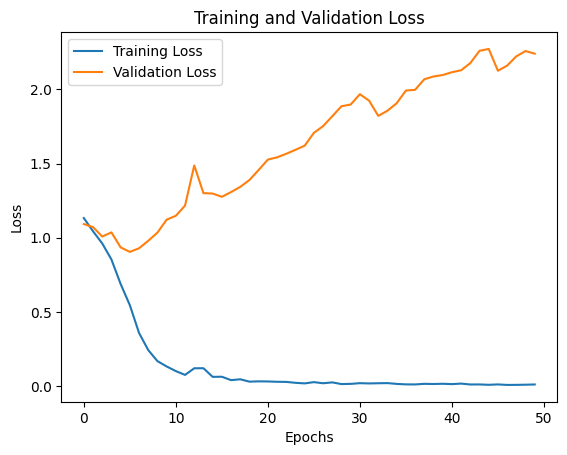

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score_macro: 0.4773 - loss: 2.1322 


[2.110212564468384, 0.473630428314209]

In [ ]:
plot_history(history_layer_1)

model_layer_1.evaluate(X_test.values, y_test)

#### **Variasi 2**

In [ ]:
# Variasi 2 - 2 Layer RNN
model_layer_2 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(32, return_sequences=True),
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_layer_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 77, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,267 (731.51 KB)

 Trainable params: 187,267 (731.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_layer_2.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_layer_2 = model_layer_2.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - f1_score_macro: 0.4588 - loss: 1.0967 - val_f1_score_macro: 0.4366 - val_loss: 1.0720
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4554 - loss: 0.9762 - val_f1_score_macro: 0.4017 - val_loss: 1.0305
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score_macro: 0.4499 - loss: 0.9060 - val_f1_score_macro: 0.4585 - val_loss: 1.0196
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4733 - loss: 0.7857 - val_f1_score_macro: 0.4563 - val_loss: 0.9812
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4775 - loss: 0.5990 - val_f1_score_macro: 0.4648 - val_loss: 1.1103
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4897 - loss: 0.4202 - val_f1_score_macro: 0.4809 - val_loss: 1.1549
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score_macro: 0.4915 - loss: 0.3152 - val_f1_score_macro: 0.4896 - val_loss: 1.2261
Epoch 8/50
16/16 ━━━━━━━━━━

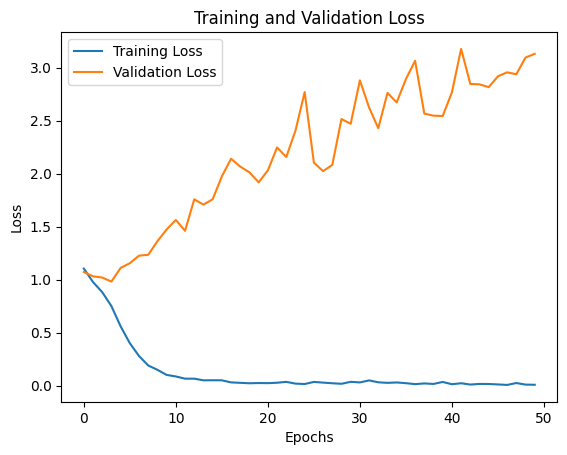

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score_macro: 0.4899 - loss: 3.2496 


[3.321539878845215, 0.4865334928035736]

In [ ]:
plot_history(history_layer_2)

model_layer_2.evaluate(X_test.values, y_test)

#### **Variasi 3**

In [ ]:
# Variasi 3 - 3 Layer RNN
model_layer_3 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(32, return_sequences=True),
            LSTM(32, return_sequences=True),
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_layer_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 77, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 77, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,347 (739.64 KB)

 Trainable params: 189,347 (739.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_layer_3.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_layer_3 = model_layer_3.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - f1_score_macro: 0.4651 - loss: 1.1998 - val_f1_score_macro: 0.4757 - val_loss: 1.1196
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - f1_score_macro: 0.4626 - loss: 1.0930 - val_f1_score_macro: 0.4953 - val_loss: 1.1471
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - f1_score_macro: 0.4835 - loss: 0.8647 - val_f1_score_macro: 0.4820 - val_loss: 1.1329
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - f1_score_macro: 0.4869 - loss: 0.7247 - val_f1_score_macro: 0.4831 - val_loss: 1.1314
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - f1_score_macro: 0.4796 - loss: 0.5653 - val_f1_score_macro: 0.4999 - val_loss: 1.1937
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - f1_score_macro: 0.4937 - loss: 0.4534 - val_f1_score_macro: 0.4892 - val_loss: 1.2676
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - f1_score_macro: 0.4895 - loss: 0.3063 - val_f1_score_macro: 0.4903 - val_loss: 1.3668
Epoch 8/50
16/16 ━━━━━━━━━━

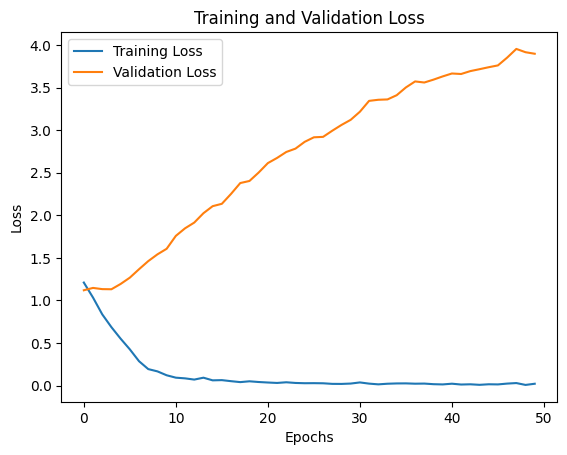

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score_macro: 0.4813 - loss: 3.1361


[3.1751043796539307, 0.4777250587940216]

In [ ]:
plot_history(history_layer_3)

model_layer_3.evaluate(X_test.values, y_test)

### **Pengaruh Jumlah Cell**

#### **Variasi 1**

In [ ]:
# Variasi 1
model_cell_1 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_cell_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,187 (723.39 KB)

 Trainable params: 185,187 (723.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_cell_1.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_cell_1 = model_cell_1.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - f1_score_macro: 0.4753 - loss: 1.0987 - val_f1_score_macro: 0.3800 - val_loss: 1.0444
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4508 - loss: 0.9729 - val_f1_score_macro: 0.4998 - val_loss: 1.0948
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4627 - loss: 0.8866 - val_f1_score_macro: 0.4077 - val_loss: 0.9922
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4541 - loss: 0.7448 - val_f1_score_macro: 0.4767 - val_loss: 0.9544
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4819 - loss: 0.5680 - val_f1_score_macro: 0.4875 - val_loss: 0.9905
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4888 - loss: 0.4276 - val_f1_score_macro: 0.4934 - val_loss: 1.0287
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4929 - loss: 0.3416 - val_f1_score_macro: 0.4817 - val_loss: 1.0316
Epoch 8/50
16/16 ━━━━━━━━━━

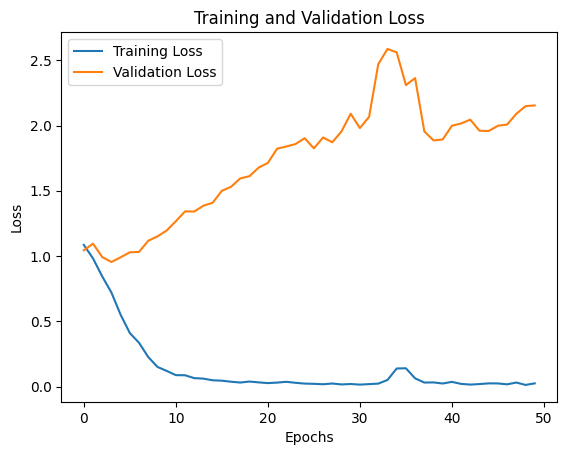

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score_macro: 0.4900 - loss: 2.0650 


[1.984969139099121, 0.4827241003513336]

In [ ]:
plot_history(history_cell_1)

model_cell_1.evaluate(X_test.values, y_test)

#### **Variasi 2**

In [ ]:
# Variasi 2
model_cell_2 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(64),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_cell_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,851 (745.51 KB)

 Trainable params: 190,851 (745.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_cell_2.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_cell_2 = model_cell_2.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - f1_score_macro: 0.4902 - loss: 1.1128 - val_f1_score_macro: 0.4015 - val_loss: 1.0655
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4740 - loss: 0.9903 - val_f1_score_macro: 0.4257 - val_loss: 1.0026
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4722 - loss: 0.9179 - val_f1_score_macro: 0.4223 - val_loss: 1.0271
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4785 - loss: 0.7642 - val_f1_score_macro: 0.4400 - val_loss: 0.9791
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1_score_macro: 0.4885 - loss: 0.5805 - val_f1_score_macro: 0.4482 - val_loss: 1.0338
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4914 - loss: 0.4363 - val_f1_score_macro: 0.4524 - val_loss: 1.0523
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4989 - loss: 0.3177 - val_f1_score_macro: 0.4674 - val_loss: 1.0673
Epoch 8/50
16/16 ━━━━━━━━━━

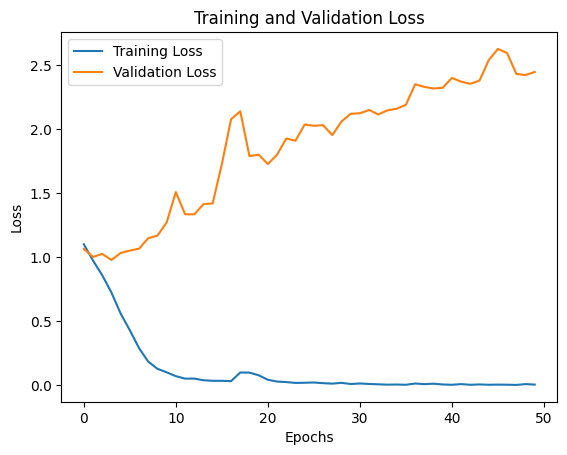

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score_macro: 0.4753 - loss: 2.6544 


[2.616244316101074, 0.4725218713283539]

In [ ]:
plot_history(history_cell_2)

model_cell_2.evaluate(X_test.values, y_test)

#### **Variasi 3**

In [ ]:
# Variasi 3
model_cell_3 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(128),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_cell_3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,323 (813.76 KB)

 Trainable params: 208,323 (813.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_cell_3.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_cell_3 = model_cell_3.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - f1_score_macro: 0.4873 - loss: 1.0847 - val_f1_score_macro: 0.4734 - val_loss: 1.0574
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.4889 - loss: 0.9651 - val_f1_score_macro: 0.4711 - val_loss: 0.9881
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score_macro: 0.4835 - loss: 0.8566 - val_f1_score_macro: 0.4779 - val_loss: 1.0212
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score_macro: 0.5006 - loss: 0.6596 - val_f1_score_macro: 0.4773 - val_loss: 1.0935
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score_macro: 0.5003 - loss: 0.4498 - val_f1_score_macro: 0.4332 - val_loss: 1.2208
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score_macro: 0.4944 - loss: 0.3011 - val_f1_score_macro: 0.4947 - val_loss: 1.6475
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score_macro: 0.5088 - loss: 0.2607 - val_f1_score_macro: 0.4713 - val_loss: 1.1990
Epoch 8/50
16/16 ━━━━━━━━━━

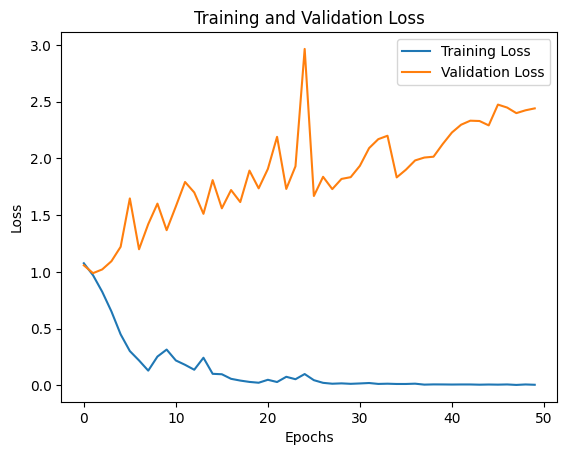

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score_macro: 0.4539 - loss: 2.7788


[2.616992235183716, 0.4552343785762787]

In [ ]:
plot_history(history_cell_3)

model_cell_3.evaluate(X_test.values, y_test)

### **Pengaruh Arah**

#### **Variasi Unidirectional**

In [ ]:
# Unidirectional
model_uni = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_uni.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,187 (723.39 KB)

 Trainable params: 185,187 (723.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_uni.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_uni = model_uni.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - f1_score_macro: 0.4707 - loss: 1.0996 - val_f1_score_macro: 0.4483 - val_loss: 1.0821
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4473 - loss: 1.0304 - val_f1_score_macro: 0.4446 - val_loss: 1.0544
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4498 - loss: 0.9217 - val_f1_score_macro: 0.4549 - val_loss: 1.0159
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4568 - loss: 0.7951 - val_f1_score_macro: 0.4583 - val_loss: 0.9837
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4742 - loss: 0.6585 - val_f1_score_macro: 0.4623 - val_loss: 1.0604
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4875 - loss: 0.5246 - val_f1_score_macro: 0.4876 - val_loss: 0.9742
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - f1_score_macro: 0.4954 - loss: 0.3769 - val_f1_score_macro: 0.4871 - val_loss: 1.0423
Epoch 8/50
16/16 ━━━━━━━━━━

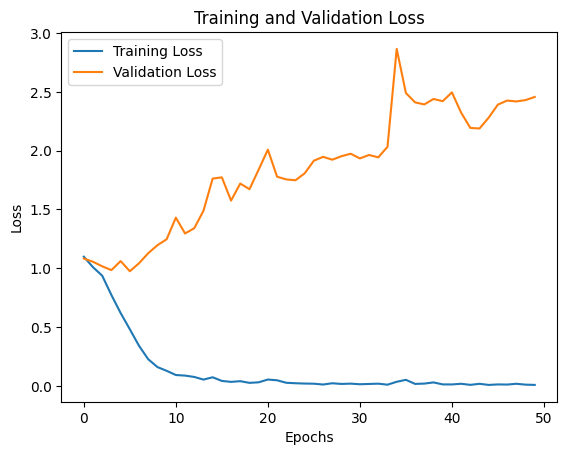

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score_macro: 0.4830 - loss: 2.1189 


[2.1677896976470947, 0.4775260388851166]

In [ ]:
plot_history(history_uni)

model_uni.evaluate(X_test.values, y_test)

#### **Variasi Bidirectional**

In [ ]:
# Bidirectional
model_bi = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # RNN layers for sequence modeling
            Bidirectional(LSTM_c(32)),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_bi.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,803 (737.51 KB)

 Trainable params: 188,803 (737.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_bi.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_bi = model_bi.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - f1_score_macro: 0.5009 - loss: 1.1197 - val_f1_score_macro: 0.4197 - val_loss: 1.0662
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4662 - loss: 1.0313 - val_f1_score_macro: 0.4555 - val_loss: 1.0187
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4749 - loss: 0.9024 - val_f1_score_macro: 0.4171 - val_loss: 0.9820
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4786 - loss: 0.7851 - val_f1_score_macro: 0.4841 - val_loss: 0.9496
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4925 - loss: 0.6381 - val_f1_score_macro: 0.4942 - val_loss: 0.9571
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4972 - loss: 0.4700 - val_f1_score_macro: 0.4829 - val_loss: 0.9508
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score_macro: 0.4921 - loss: 0.3361 - val_f1_score_macro: 0.4828 - val_loss: 0.9746
Epoch 8/50
16/16 ━━━━━━━━━━

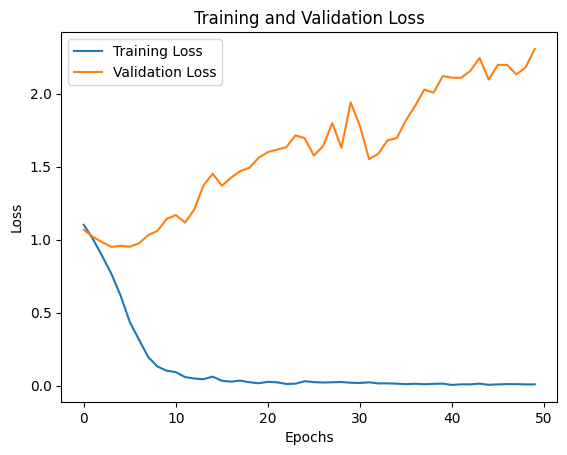

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score_macro: 0.4845 - loss: 2.4365 


[2.3459513187408447, 0.48185816407203674]

In [ ]:
plot_history(history_bi)

model_bi.evaluate(X_test.values, y_test)

## **Perbandingan dengan model from _scratch_**

In [ ]:
config = vectorize_layer.get_config()
sequence_length_from_config = config['output_sequence_length']

print(sequence_length_from_config)

77


In [ ]:
vectorized_train_text = vectorize_layer(X_train)
vectorized_valid_text = vectorize_layer(X_valid)
vectorized_test_text = vectorize_layer(X_test)

In [ ]:
model_keras = Sequential([
          Embedding(
              input_dim=len(vectorize_layer.get_vocabulary()),
              output_dim=64,
              mask_zero=True
          ),

          # RNN layers for sequence modeling
          Bidirectional(LSTM_c(32)),

          # Dense layers
          Dropout(0.5),
          Dense(16, activation='relu'),
          Dropout(0.3),
          Dense(3, activation='softmax')
      ])

In [ ]:
model_keras.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_keras = model_keras.fit(vectorized_train_text, y_train, epochs=50, validation_data=(vectorized_valid_text, y_valid), callbacks=[early_stopping_callback])
model_keras.summary()
model_keras.save("keras_model.h5")

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - f1_score_macro: 0.4853 - loss: 1.1550 - val_f1_score_macro: 0.4931 - val_loss: 1.1141
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4980 - loss: 1.0669 - val_f1_score_macro: 0.4726 - val_loss: 1.0929
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4767 - loss: 0.9719 - val_f1_score_macro: 0.4162 - val_loss: 1.0532
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4658 - loss: 0.8712 - val_f1_score_macro: 0.4382 - val_loss: 0.9986
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4754 - loss: 0.7025 - val_f1_score_macro: 0.4940 - val_loss: 0.9198
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - f1_score_macro: 0.4931 - loss: 0.4960 - val_f1_score_macro: 0.4812 - val_loss: 0.9021
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - f1_score_macro: 0.4940 - loss: 0.3369 - val_f1_score_macro: 0.4735 - val_loss: 0.9191
Epoch 8/50
16/16 ━━━━━━━━━━

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 566,411 (2.16 MB)

 Trainable params: 188,803 (737.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 377,608 (1.44 MB)

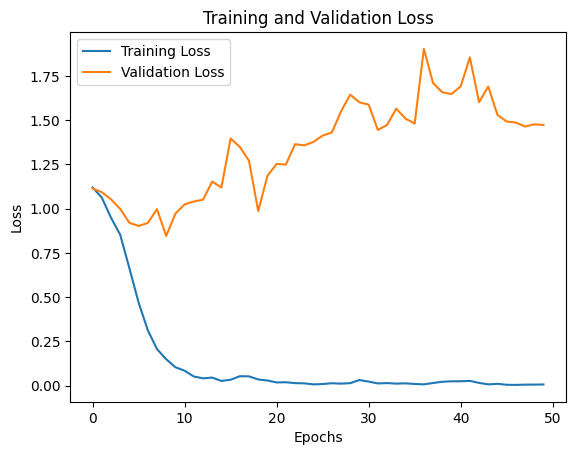

In [ ]:
plot_history(history_keras)

In [ ]:
keras_loss, keras_f1_macro = model_keras.evaluate(vectorized_test_text, y_test, verbose=0)
print(f"Keras Test Loss: {keras_loss:.4f}")
print(f"Keras Test F1-score (macro): {keras_f1_macro:.4f}")

Keras Test Loss: 1.3997
Keras Test F1-score (macro): 0.4791


In [ ]:
from lstm_layer import *

model_custom = Model([
    Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64),
    Bidirectional(LSTM_c(units=32, input_size=64)),
    Dropout(0.5),
    Dense(16, input_size=64, activation_function='relu'),
    Dropout(0.3),
    Dense(3, input_size=16, activation_function='softmax')
])

In [ ]:
model_custom.load_weights_from_keras_model('keras_model.h5')

In [ ]:
keras_output = model_keras.predict(vectorized_test_text)
custom_output = model_custom.predict(vectorized_test_text)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
print("\nSampel Output Mentah (5 sampel pertama):")
for i in range(min(5, len(keras_output))):
    print(f"Sampel {i+1}:")
    print(f"  Keras : {keras_output[i]}")
    print(f"  Custom: {custom_output[i]}")
    print("-" * 20)


Sampel Output Mentah (5 sampel pertama):
Sampel 1:
  Keras : [0.04768137 0.04381198 0.90850663]
  Custom: [0.78032523 0.13101201 0.08866271]
--------------------
Sampel 2:
  Keras : [5.7211175e-04 9.9919623e-01 2.3167621e-04]
  Custom: [0.35973033 0.6046903  0.03557932]
--------------------
Sampel 3:
  Keras : [0.98550934 0.00981039 0.00468027]
  Custom: [0.03304055 0.10795928 0.8590002 ]
--------------------
Sampel 4:
  Keras : [5.9174810e-05 3.2529498e-03 9.9668795e-01]
  Custom: [0.01002365 0.20789024 0.78208613]
--------------------
Sampel 5:
  Keras : [0.04422392 0.8946252  0.06115089]
  Custom: [0.0237069 0.0642923 0.9120008]
--------------------


In [ ]:
abs_diff = np.mean(np.abs(keras_output - custom_output))
print(f"Perbedaan absolut rata-rata antara output Keras dan Custom: {abs_diff:.6f}")

Perbedaan absolut rata-rata antara output Keras dan Custom: 0.298264


In [ ]:
print(f"F1-score Macro Model Keras: {keras_f1_macro:.4f}")

y_pred_custom_labels = np.argmax(custom_output, axis=1)

custom_f1_macro = f1_score(y_test, y_pred_custom_labels, average='macro')
print(f"F1-score Macro Model Custom: {custom_f1_macro:.4f}")

print("\nPerbandingan F1-score Macro:")
print(f"  Keras : {keras_f1_macro:.4f}")
print(f"  Custom: {custom_f1_macro:.4f}")

print("\nLaporan Klasifikasi Model Custom:")
report_custom = classification_report(y_test.values, y_pred_custom_labels, target_names=label_map.keys())
print(report_custom)

y_pred_keras_labels = np.argmax(keras_output, axis=1)
keras_f1_macro_from_predict = f1_score(y_test, y_pred_keras_labels, average='macro')
print(f"\nF1-score Macro Model Keras (dari predict, untuk perbandingan langsung): {keras_f1_macro_from_predict:.4f}")
print("\nLaporan Klasifikasi Model Keras (dari predict):")
report_keras_predict = classification_report(y_test.values, y_pred_keras_labels, target_names=label_map.keys())
print(report_keras_predict)

F1-score Macro Model Keras: 0.4791
F1-score Macro Model Custom: 0.3874

Perbandingan F1-score Macro:
  Keras : 0.4791
  Custom: 0.3874

Laporan Klasifikasi Model Custom:
              precision    recall  f1-score   support

    negative       0.41      0.31      0.36       153
     neutral       0.37      0.20      0.26        96
    positive       0.45      0.70      0.55       151

    accuracy                           0.43       400
   macro avg       0.41      0.40      0.39       400
weighted avg       0.42      0.43      0.41       400


F1-score Macro Model Keras (dari predict, untuk perbandingan langsung): 0.6171

Laporan Klasifikasi Model Keras (dari predict):
              precision    recall  f1-score   support

    negative       0.68      0.53      0.59       153
     neutral       0.52      0.53      0.52        96
    positive       0.67      0.81      0.73       151

    accuracy                           0.64       400
   macro avg       0.62      0.62      0.62     